In [25]:
"""
To obtain the token use GDAuth
https://gdauth.readthedocs.io/en/latest/source/usage.html

gdauth init
gdauth select



"""
!pip install globus_sdk
import h5py
import fsspec
from globus_sdk import AccessTokenAuthorizer, TransferClient

def open_hdf5_dataset_globus(url, dataset_path, subdataset_slice=None, token=None):
    """
    Opens an HDF5 file on Globus and retrieves a specific dataset, with an optional slice.
    
    Args:
        url (str): The Globus URL or endpoint to the HDF5 file.
        dataset_path (str): Path to the desired dataset within the HDF5 file.
        subdataset_slice (tuple, optional): Slice of the dataset (e.g., [:, :10]). Defaults to None.
        token (str, optional): Globus access token for authentication. Defaults to None.
    
    Returns:
        numpy.ndarray: The requested dataset or slice as a NumPy array.
    """
    if not token:
        raise ValueError("A Globus access token is required to access the file.")
    
    # Use fsspec with Globus token for file access
    fs = fsspec.filesystem("https", headers={"Authorization": f"Bearer {token}"})
    with fs.open(url, "rb") as f:
        with h5py.File(f, "r") as hdf5_file:
            dataset = hdf5_file[dataset_path]
            return dataset[subdataset_slice] if subdataset_slice else dataset[:]


import h5py
import fsspec

def list_hdf5_structure_globus(url, token):
    """
    Lists all groups and datasets in an HDF5 file hosted on Globus.
    
    Args:
        url (str): The URL to the HDF5 file.
        token (str): Globus access token for authentication.
    
    Returns:
        None: Prints the structure of the HDF5 file.
    """
    fs = fsspec.filesystem("https", headers={"Authorization": f"Bearer {token}"})
    with fs.open(url, "rb") as f:
        with h5py.File(f, "r") as hdf5_file:
            def print_structure(name, obj):
                if isinstance(obj, h5py.Group):
                    print(f"Group: {name}")
                elif isinstance(obj, h5py.Dataset):
                    print(f"Dataset: {name}")

            hdf5_file.visititems(print_structure)



import fsspec
import imageio.v3 as iio  # Modern interface for reading images, including TIFF
import matplotlib.pyplot as plt

def get_globus_tiff(url, token):
    """
    Retrieve a TIFF file from a Globus URL and display it.
    
    Args:
        url (str): The Globus URL to the TIFF file.
        token (str): Authentication token for Globus.
    
    Returns:
        None: Displays the TIFF image.
    """
    # Use fsspec with the Globus token to retrieve the file
    fs = fsspec.filesystem("https", headers={"Authorization": f"Bearer {token}"})
    with fs.open(url, "rb") as f:
        # Read the TIFF file into memory
        data = iio.imread(f)
        
        # Display the image
        plt.figure(figsize=(8, 8))
        plt.imshow(data, cmap="gray")  # Use cmap="gray" for grayscale TIFFs
        plt.axis("off")  # Hide axes for better visualization
        plt.title("Retrieved Image")
        plt.show()
    return data

In [34]:
url='https://g-df2e9.fd635.8443.data.globus.org/ESRF_BM18/MD1290-25April24/HA115_4.349um_715697L_0003/md1290_HA115_4.349um_715697L_0003.h5'
dataset_path='/exchange/data'
token='2f1fd715-ee09-43f9-9b48-1f06810bcc70'

list_hdf5_structure_globus(url,token)

In [12]:
data = open_hdf5_dataset_globus(url, dataset_path, subdataset_slice=(slice(0, 10), slice(0, 10)),token=token)

print(data)

KeyError: 'Unable to open object (component not found)'

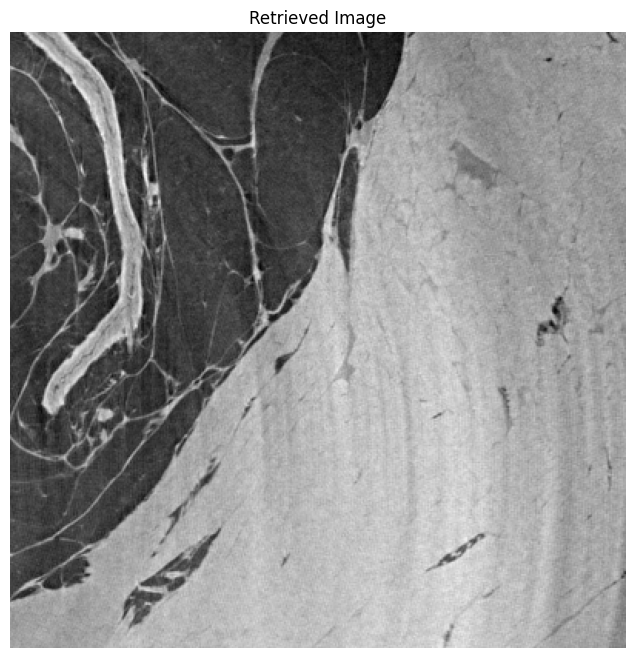

In [27]:
url='https://g-df2e9.fd635.8443.data.globus.org/DXC_2024/DataSets/Chiken_leg/PhaseRetrieved/PhaseRetrieved_0091.tif'

data = get_globus_tiff(url,token)

In [35]:
import fsspec
import imageio.v3 as iio
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

class RemoteTIFFLoader:
    """
    A class to handle lazy loading of TIFF slices from a remote directory.
    """
    def __init__(self, directory_url, token=None):
        """
        Initialize the loader with the remote directory URL and authentication token.
        Args:
            directory_url (str): The URL of the remote directory containing TIFF files.
            token (str, optional): Authentication token for the remote server. Defaults to None.
        """
        self.directory_url = directory_url
        self.token = token
        self.fs = fsspec.filesystem("https", headers={"Authorization": f"Bearer {token}"} if token else None)
        self.file_list = self._get_file_list()
        if not self.file_list:
            raise ValueError("No TIFF files found in the specified remote directory.")

    def _get_file_list(self):
        """
        Retrieve the list of TIFF files in the remote directory.
        Returns:
            list: Sorted list of TIFF file URLs.
        """
        files = self.fs.glob(f"{self.directory_url}/*.tif*")  # List files in the directory
        return sorted(files)  # Ensure files are sorted

    def get_total_slices(self):
        """
        Returns the total number of slices in the remote directory.
        Returns:
            int: Number of TIFF files (slices).
        """
        return len(self.file_list)

    def get_slice(self, index):
        """
        Lazily loads a specific slice (TIFF file) from the remote directory.
        Args:
            index (int): The slice index to load.
        Returns:
            numpy.ndarray: The loaded slice as a 2D NumPy array.
        """
        if index < 0 or index >= len(self.file_list):
            raise IndexError(f"Index {index} is out of range (0-{len(self.file_list) - 1}).")
        with self.fs.open(self.file_list[index], "rb") as f:
            return iio.imread(f)

def display_remote_tiff_stack_with_slider(loader):
    """
    Display a lazily loaded stack of TIFF files from a remote directory with a slider.
    Args:
        loader (RemoteTIFFLoader): An instance of the RemoteTIFFLoader class.
    Returns:
        None
    """
    # Retrieve the total number of slices
    total_slices = loader.get_total_slices()

    # Initial index for the slider
    initial_index = 0
    initial_slice = loader.get_slice(initial_index)

    # Create the figure and axis for displaying images
    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.25)  # Adjust layout to make space for the slider
    img_display = ax.imshow(initial_slice, cmap="gray")
    ax.set_title(f"Slice {initial_index + 1}/{total_slices}")
    ax.axis("off")

    # Create the slider axis and slider widget
    ax_slider = plt.axes([0.2, 0.1, 0.65, 0.03])
    slider = Slider(ax_slider, "Slice", 0, total_slices - 1, valinit=initial_index, valstep=1)

    # Update function for the slider
    def update(val):
        index = int(slider.val)  # Get the current slider value
        new_slice = loader.get_slice(index)  # Lazily load the slice
        img_display.set_data(new_slice)  # Update the displayed image
        ax.set_title(f"Slice {index + 1}/{total_slices}")
        fig.canvas.draw_idle()  # Redraw the figure

    # Connect the slider to the update function
    slider.on_changed(update)

    plt.show()

# Example usage
remote_directory_url = "https://example.globus.org/data/tiff_directory/"  # Replace with the URL to your remote directory



url='https://g-df2e9.fd635.8443.data.globus.org/DXC_2024/DataSets/Chiken_leg/PhaseRetrieved/'
# Create a remote directory loader instance
remote_loader = RemoteTIFFLoader(url, token)

# Display the TIFF stack with lazy loading
display_remote_tiff_stack_with_slider(remote_loader)

ValueError: No TIFF files found in the specified remote directory.

In [38]:
import fsspec
token='2f1fd715-ee09-43f9-9b48-1f06810bcc70'

url = 'https://g-df2e9.fd635.8443.data.globus.org/DXC_2024/DataSets/Chiken_leg/PhaseRetrieved/'

fs = fsspec.filesystem("https", headers={"Authorization": f"Bearer {token}"})
files = fs.glob(f"{url}/*")  # List all files in the directory
print("Directory listing:", files)


Directory listing: []
